# **Topic: Cryptography**
Team members:

*   Teresa Lee
*   Tino Trangia
*   Derrick Yao

DSC 210 Final Project (Fall 2024)





## **Experiment goal**: Compare two hybrid encryption systems


*   Rivest-Shamir-Adleman (RSA) + Advanced Encryption Standard (AES)
*   Elliptic Curve Integrated Encryption Scheme (ECIES)



In [88]:
# install dependencies
%pip install pycryptodome
%pip install eciespy

In [89]:
# imports
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.PublicKey import ECC
from ecies.utils import generate_eth_key
from ecies import encrypt, decrypt
import binascii, os
import matplotlib.pyplot as plt
import numpy as np
import time

## **AES Implementation**

We will be using the [pycryptodome](https://pycryptodome.readthedocs.io/en/latest/index.html) library which provides use with implementations of various cryptosystems such as AES, RSA, and ECC. Specifically, we wil be implementing AES-256-GCM. This is one of the most common schemes built around AES. It uses a 256-bit key and applies AES in the [Galois/Counter Mode of Operation](https://en.wikipedia.org/wiki/Galois/Counter_Mode). It provides confidentiality, authentication, and integrity. The former 2 are provided as part of the cipher itself (i.e. the message is confidential and the identity of the sender is trivially verified by the fact that they possess the same secret key). Integrity is added on with a message authentication code (MAC) so that the receiver can verify that the message has not been tampered with.

In [90]:
# implement the encryption and decryption functions for AES

def AES_encrypt(msg, key):
  cipher = AES.new(key, AES.MODE_GCM) # initialize the AES function with a key and the mode of operation
  ciphertext, authTag = cipher.encrypt_and_digest(msg) # encrypt the message
  return (ciphertext, cipher.nonce, authTag) # return the encrypted message (ciphertext), the initial vector (nonce, needed for decryption but can be public), and the authentication tag

def AES_decrypt(encryptedPackage, key):
  (ciphertext, nonce, authTag) = encryptedPackage
  cipher = AES.new(key, AES.MODE_GCM, nonce) # initialize the same AES function using the secret key, initial vector, and same mode of operation
  plaintext = cipher.decrypt_and_verify(ciphertext, authTag) # decrypt the message
  return plaintext


### Testing our implementation

In [91]:
key = os.urandom(32) # generate 32-byte (256-bit) key using a random number generator that is "non-deterministic" and cryptographically safe (uses entropy from OS data)
print("Secret key: ", binascii.hexlify(key)) # we use binascii.hexlify conversion to represent the bytes as hexadecimals

msg = b'Hello world. This is a message to be encrypted.'
encryptedPackage = AES_encrypt(msg, key)
print("Plaintext: ", binascii.hexlify(msg))
print("Ciphertext: ", binascii.hexlify(encryptedPackage[0]))

Secret key:  b'e6706db84e977e75c00fee578f461e473ca423e80fd4737d56fdeb9413e9c7cf'
Plaintext:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Ciphertext:  b'4d1b4fc055431712b3f68480c68a1ca676f09a40a83819d248d26e4e3b589185173e89f691a943405e4454e32c930e'


As we can see above, AES took our message and transformed it into an a different byte string. Now, we will decrypt the message.

In [92]:
receivedMsg = AES_decrypt(encryptedPackage, key)
print("Received message: ", binascii.hexlify(receivedMsg))
print("Received message (in English): ", receivedMsg)

Received message:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Received message (in English):  b'Hello world. This is a message to be encrypted.'


As expected, we have the original message back. But, how do we know that integrity works? We can do some tampering on the message before decryption.

In [93]:
tamperedPackage = (b'Hello world. This message has been corrupted.', encryptedPackage[1], encryptedPackage[2])
try:
  receivedMsg = AES_decrypt(tamperedPackage, key)
except Exception as e:
  print(e)

MAC check failed


Since the ciphertext and MAC must match, we receive an error. The same would happen if instead of tampering the ciphertext, someone tampered with the MAC. Both must match in order to pass decryption.

### Preliminary Analysis

Next, before we compare hybrid encryption schemes, we will evaluate AES against itself. We will compare the speeds of AES as a function of both key size and message size.

In [94]:
# create helper function that performs both encryption and decryption and also generates a key of given size in bytes

def AES_encrypt_and_decrypt(msg, key):
  encryptedPackage = AES_encrypt(msg, key)
  receivedMsg = AES_decrypt(encryptedPackage, key)
  return

In [95]:
# This will take about 15s to run
keySizes = [16, 24, 32] # sizes in B
messageSizes = np.arange(1, 1025, 16) # sizes in KB
results = {keySize: [] for keySize in keySizes}


for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024 # multiply sizes in KB by number of bytes in KB to generate default message
  for keySize in keySizes:
    cumulative_time = 0
    n = 30
    for _ in np.arange(n): # average the runtime over n iterations to smooth out noise
      key = os.urandom(keySize)
      start_time = time.perf_counter()
      AES_encrypt_and_decrypt(msg, key)
      cumulative_time += time.perf_counter() - start_time
    average_time = cumulative_time / n
    results[keySize].append(average_time)


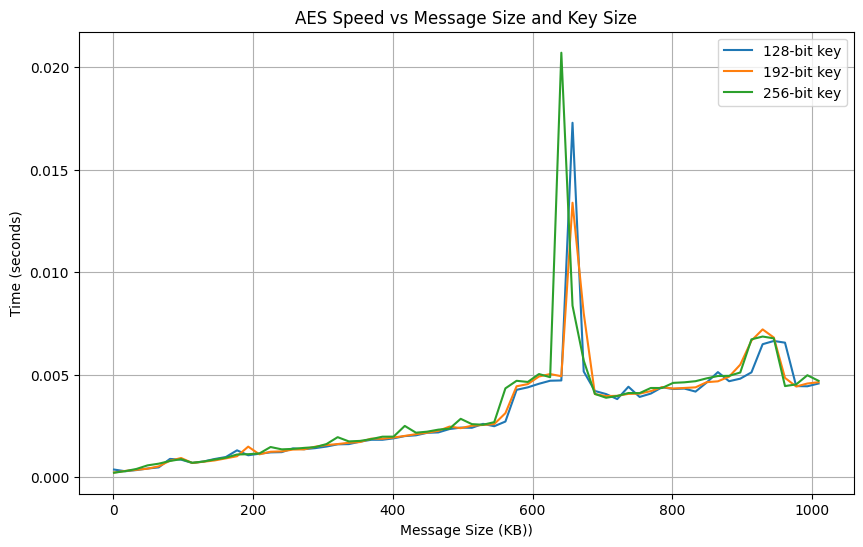

In [96]:
plt.figure(figsize=(10, 6))
for keySize, times in results.items():
  plt.plot(messageSizes, times, label=f'{keySize * 8}-bit key')

plt.xlabel('Message Size (KB))')
plt.ylabel('Time (seconds)')
plt.title('AES Speed vs Message Size and Key Size')
plt.legend()
plt.grid()
plt.show()

As expected, the larger the message, the more time it takes to encrypt and decrypt. However, the difference is unclear in speed for key sizes. This could be due to several factors:


*   Limited message size prevents the trend from being shown
*   Noise generated by limited precision of timing and hardware
*   Limiting factors that are not related to the encryption algorithm such as RAM speed, CPU, etc.



## **RSA Implementation**

Next, we will implement RSA. More specifically, we are implementing RSA-KEM (RSA-Key Encapsulation Mechanism). This is a hybrid encryption scheme that uses RSA to encrypt and share the secret symmetric key which is then used to encrypt/decrypt the message itself using AES. In practice, we essentially use RSA to generate a session key for some data. We use [PKCS#1 OAEP](https://pycryptodome.readthedocs.io/en/latest/src/cipher/oaep.html) as the implementation for RSA encryption. It combines standard RSA with a padding algorithm for secure encryption.


In [97]:
# Takes keySize in bits and generates public-private key pair
# Recommended minimum is 2048 bits. 3072 or 4096 bit is also a common choice.
def RSA_key_generate(keySize):
  keyPair = RSA.generate(keySize)
  publicKey = keyPair.publickey()
  privateKey = keyPair
  return publicKey, keyPair


# function takes a symmetric key for AES, a RSA publicKey for asymmetric encryption, and the message
def RSA_AES_encrypt(symKey, publicKey, msg):
  cipherRSA = PKCS1_OAEP.new(publicKey) # initialize RSA encryption function with the recipients public key
  keyCapsule = cipherRSA.encrypt(symKey) # encrypt the symmetric key with RSA
  encryptedPackage = AES_encrypt(msg, symKey) # encrypt the message using AES and symmetric key
  return encryptedPackage, keyCapsule # send both the encapsulated key and the encrypted message

# function takes an encrypted message, an encrypted key, and user's private key
def RSA_AES_decrypt(encryptedPackage, keyCapsule, privateKey):
  cipherRSA = PKCS1_OAEP.new(privateKey) # initialize RSA decryption function with private key
  symKey = cipherRSA.decrypt(keyCapsule) # decrypt the symmetric key
  plaintext = AES_decrypt(encryptedPackage, key) # decrypt the message
  return plaintext


Lets test a message with this hybrid encryption system.

In [98]:
key = os.urandom(32)
msg = b'Hello world. This is a message to be encrypted.'

# Usually we have to generate two key pairs, one for receiver and one for sender (we'll only use one though)
publicKey, privateKey = RSA_key_generate(2048)

encryptedPackage, keyCapsule = RSA_AES_encrypt(key, publicKey, msg)

print("Plaintext: ", binascii.hexlify(msg))
print("Ciphertext: ", binascii.hexlify(encryptedPackage[0]))

Plaintext:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Ciphertext:  b'3e17d4bf757ae1e640d0620516a9d346af301613c7de0e6ed71825582b56059de2b0b121cfcc193e159ff922a0540d'


In [99]:
receivedMsg = RSA_AES_decrypt(encryptedPackage, keyCapsule, privateKey)
print("Received message: ", binascii.hexlify(receivedMsg))
print("Received message (in English): ", receivedMsg)

Received message:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Received message (in English):  b'Hello world. This is a message to be encrypted.'


## **ECIES Implementation**

Now, we implement the state-of-the-art method, elliptic curve cryptography. We are using the Elliptic Curve Integrated Encryption Scheme as the framework for our hybrid encryption. We will switch over to the [eciespy](https://pypi.org/project/eciespy/) library for ease of implementation. This library uses the secp256k1 curve which is used by Bitcoin along with AES-256-GCM. Note that we can't control the key size here, though typical key length is 256 bits, as it is for this curve. Notice also that we do not get to choose the symmetric key - this is randomly derived in the key exchange step.

In [100]:
def ECIES_key_generate():
  privateKey = generate_eth_key()
  publicKey = privateKey.public_key
  return privateKey, publicKey

We will use ecies built in encrypt and decrypt function. Let's do a quick test.

In [101]:
msg = b'Hello world. This is a message to be encrypted.'

privateKey, publicKey = ECIES_key_generate()
encrypted = encrypt(publicKey.to_hex(), msg)
print("Plaintext: ", binascii.hexlify(msg))
print("Ciphertext: ", binascii.hexlify(encrypted))

Plaintext:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Ciphertext:  b'04d165afd2e58acc87d8513966867bf4f07666ee0efeff295ec4256fb2b4cc8d403b69b826873bbf9c5c9a4247e2c522affdbba8f7d4611053815e383603690a15e12328346ec3edab1dd29b086d455b1f42d3c0defbc04e77e08e3d486c07ed68a55b9ab0207a5b0b33b3cf851f673c4385a56c03e6312c1c3be438e4266e0a3d3a53d120e1b5bcbb3c882f81c45d0c'


Notice that the ciphertext appears longer than the plaintext, unlike in the previous caes. This is actually because the output actually includes the cipher public key, AES nonce, authTag, and the ciphertext, in that order. It is packed in binary form and will automatically be split in the decryption function.

In [102]:
receivedMsg = decrypt(privateKey.to_hex(), encrypted)
print("Received message: ", binascii.hexlify(receivedMsg))
print("Received message (in English): ", receivedMsg)

Received message:  b'48656c6c6f20776f726c642e20546869732069732061206d65737361676520746f20626520656e637279707465642e'
Received message (in English):  b'Hello world. This is a message to be encrypted.'


## Experiment

Now we are finally ready to do our experiment. We will be comparing the RSA-KEM method above with the SOTA ECIES implementation.

In [103]:
# helper function that combines key generation and encryption for RSA-KEM
def RSA_generate_encrypt(keySize, msg):
  key = os.urandom(32)
  publicKey, privateKey = RSA_key_generate(keySize)
  encryptedPackage, keyCapsule = RSA_AES_encrypt(key, publicKey, msg)
  return encryptedPackage, keyCapsule

# helper function that combines key generation and encryption for ECIES
def ECIES_generate_encrypt(msg):
  privateKey, publicKey = ECIES_key_generate()
  encrypted = encrypt(publicKey.to_hex(), msg)
  return encrypted


### First, let's compare the two approaches with the respect to message size. We'll use the default 256-bit key for ECIES and a 2048 as well as 3072 bit key for RSA. Both will use AES-256. Note that a 256-bit ECC key is roughly equivalent in strenght to a 3072 bit RSA key.

#### RSA 2048:

In [104]:
# This will take about 15s to run
messageSizes = np.arange(1, 129, 8) # sizes in KB
resultsRSA_2048 = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024 # multiply sizes in KB by number of bytes in KB to generate default message
  start_time = time.perf_counter()
  RSA_generate_encrypt(2048, msg)
  elapsed_time = time.perf_counter() - start_time
  resultsRSA_2048.append(elapsed_time)

#### RSA 3072:

In [105]:
# This will take about 60s to run (sorry, RSA is slow!)
messageSizes = np.arange(1, 129, 8) # sizes in KB
resultsRSA_3072 = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024 # multiply sizes in KB by number of bytes in KB to generate default message
  start_time = time.perf_counter()
  RSA_generate_encrypt(3072, msg)
  elapsed_time = time.perf_counter() - start_time
  resultsRSA_3072.append(elapsed_time)

#### ECIES:

In [106]:
# This will take about 3s to run
messageSizes = np.arange(1, 129, 8) # sizes in KB
resultsECIES = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024 # multiply sizes in KB by number of bytes in KB to generate default message
  start_time = time.perf_counter()
  ECIES_generate_encrypt(msg)
  elapsed_time = time.perf_counter() - start_time
  resultsECIES.append(elapsed_time)

#### Visualization:

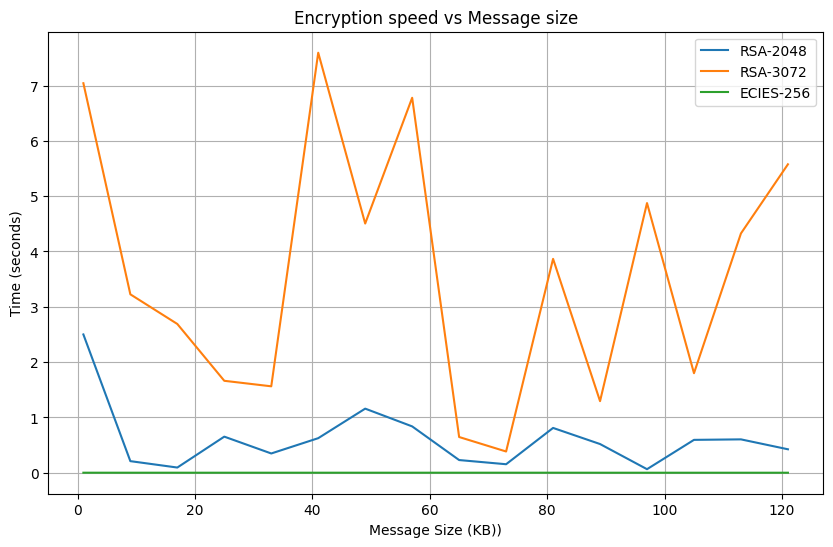

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(messageSizes, resultsRSA_2048, label="RSA-2048")
plt.plot(messageSizes, resultsRSA_3072, label="RSA-3072")
plt.plot(messageSizes, resultsECIES, label="ECIES-256")

plt.xlabel('Message Size (KB))')
plt.ylabel('Time (seconds)')
plt.title('Encryption speed vs Message size')
plt.legend()
plt.grid()
plt.show()

ECIES appears blazingly fast compared to either RSA methods. As expected, RSA-3072 is slower than RSA-2048. We also see no trend associated with message size here, suggesting that the majority of computation time is used on key genereation rather than on the symmetric encryption step.

### Now we increase the size of the messages to the order of MB

In [108]:
# This will take about 15s to run
messageSizes = np.arange(1, 129, 16) # sizes in MB
resultsRSA_2048 = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024**2 # multiply sizes in MB by number of bytes in KB to generate default message
  start_time = time.perf_counter()
  RSA_generate_encrypt(2048, msg)
  elapsed_time = time.perf_counter() - start_time
  resultsRSA_2048.append(elapsed_time)

In [109]:
# This will take about 20s to run
messageSizes = np.arange(1, 129, 16) # sizes in MB
resultsRSA_3072 = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024**2 # multiply sizes in MB by number of bytes in MB to generate default message
  start_time = time.perf_counter()
  RSA_generate_encrypt(3072, msg)
  elapsed_time = time.perf_counter() - start_time
  resultsRSA_3072.append(elapsed_time)

In [110]:
# This will take about 3s to run
messageSizes = np.arange(1, 129, 16) # sizes in MB
resultsECIES = []
for messageSize in messageSizes:
  msg = b'A' * messageSize * 1024**2 # multiply sizes in MB by number of bytes in MB to generate default message
  start_time = time.perf_counter()
  ECIES_generate_encrypt(msg)
  elapsed_time = time.perf_counter() - start_time
  resultsECIES.append(elapsed_time)

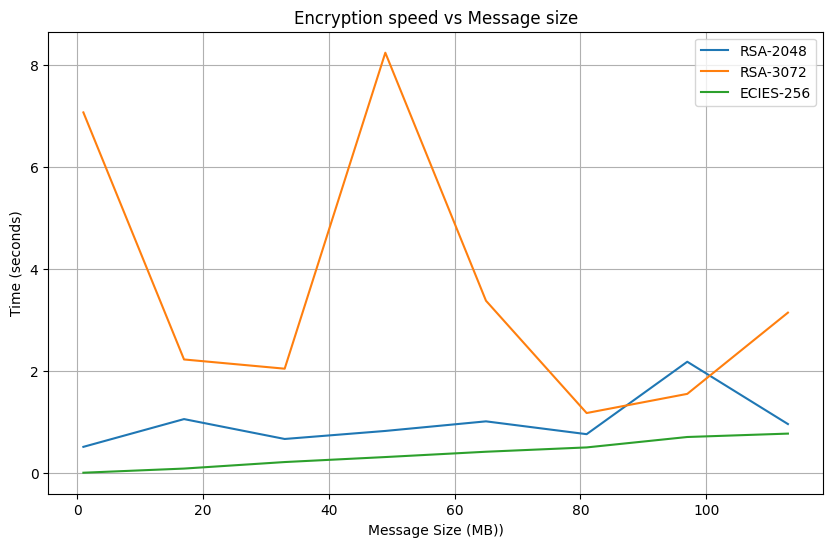

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(messageSizes, resultsRSA_2048, label="RSA-2048")
plt.plot(messageSizes, resultsRSA_3072, label="RSA-3072")
plt.plot(messageSizes, resultsECIES, label="ECIES-256")

plt.xlabel('Message Size (MB))')
plt.ylabel('Time (seconds)')
plt.title('Encryption speed vs Message size')
plt.legend()
plt.grid()
plt.show()

### Finally, lets establish some concrete numbers to summarize our comparision. We'll do a simple test with 10 messages of constant 140 B size (roughly the average size of a text message).

In [112]:
RSA_3072_time = 0
for i in np.arange(10):
  msg = b'A' * messageSize * 140
  start_time = time.perf_counter()
  RSA_generate_encrypt(3072, msg)
  RSA_3072_time += time.perf_counter() - start_time

RSA_3072_time = RSA_3072_time/10

In [113]:
ECIES_time = 0
for i in np.arange(10):
  msg = b'A' * messageSize * 140
  start_time = time.perf_counter()
  ECIES_generate_encrypt(msg)
  ECIES_time += time.perf_counter() - start_time

ECIES_time = ECIES_time/10

In [114]:
print("Average RSA-3072 encryption latency: ", RSA_3072_time)
print("Average ECIES encryption latency: ", ECIES_time)
print("Performance factor: ", RSA_3072_time / ECIES_time)

Average RSA-3072 encryption latency:  1.8484887198999786
Average ECIES encryption latency:  0.0010238800994557095
Performance factor:  1805.376157699156


In conclusion, for small messages of around 140 B, we see that ECC is over 1000 faster than the equivalent strenght RSA method.